<a href="https://colab.research.google.com/github/amyzhang-USC/Sentiment-Analysis/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install contractions

     |████████████████████████████████| 321 kB 4.9 MB/s 
     |████████████████████████████████| 284 kB 55.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85445 sha256=d500ceef6a1d587bcffac0f7313a5d3d522993f4784d01c5efec8e48bb0f745a
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
import pandas as pd
import re
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
review_data = pd.read_csv('amazon_reviews_us_Kitchen_v1_00.tsv', sep='\t', error_bad_lines=False)
pd.set_option("display.max.columns", None)

b'Skipping line 16148: expected 15 fields, saw 22\nSkipping line 20100: expected 15 fields, saw 22\nSkipping line 45178: expected 15 fields, saw 22\nSkipping line 48700: expected 15 fields, saw 22\nSkipping line 63331: expected 15 fields, saw 22\n'


In [4]:
df = review_data.head(10)
print(df)

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     37000337  R3DT59XH7HXR9K  B00303FI0G       529320574   
1          US     15272914  R1LFS11BNASSU8  B00JCZKZN6       274237558   
2          US     36137863  R296RT05AG0AF6  B00JLIKA5C       544675303   
3          US     43311049  R3V37XDZ7ZCI3L  B000GBNB8G       491599489   
4          US     13763148  R14GU232NQFYX2  B00VJ5KX9S       353790155   
5          US     19009420   RZQH4V7L2O1PL  B00HYB5YY0       432241873   
6          US     40599388  R1F8JMOSPJ3KO7  B000HEBAV2       584680984   
7          US     22719359  R1ZISGY2BWW4Z5  B0012DS4GG       772637306   
8          US     47478640  R17PW4I3AE5WZW  B00FLQ4EE6       755416578   
9          US     34195504  R3D93G1KTP6A8P  B00DBS9OTG       648762742   

                                       product_title product_category  \
0                    Arthur Court Paper Towel Holder          Kitchen   
1  Olde Thompson Bavaria Glass Salt and

In [5]:
retained_data = review_data[['review_body','star_rating']]
positive_review = retained_data[retained_data['star_rating'] > 3]
print(positive_review)
negative_review = retained_data[retained_data['star_rating'] < 3]
print(negative_review)

                                             review_body  star_rating
0                    Beautiful.  Looks great on counter.            5
1      I personally have 5 days sets and have also bo...            5
2      Fabulous and worth every penny. Used for clean...            5
3      A must if you love garlic on tomato marinara s...            5
4      Worth every penny! Buy one now and be a pizza ...            5
...                                                  ...          ...
85035               I have a full set and like them all.            5
85036  Great coffeemaker for our RV. Highly recommend...            5
85037                                       As Described            5
85038  I didn't expect much because of the price, but...            5
85039                                                NaN            5

[69200 rows x 2 columns]
                                             review_body  star_rating
5      The description says &#34;Suitable for all typ...        

In [48]:
positive_review = positive_review.sample(n=100000, replace = True)
positive_review.loc[positive_review["star_rating"] > 3, "star_rating"] = 1
negative_review = negative_review.sample(n=100000, replace = True)
negative_review.loc[negative_review["star_rating"] < 3, "star_rating"] = 0
new_df = pd.concat([positive_review, negative_review])
print(new_df)

                                             review_body  star_rating
15702  This is so handy!  It easy to remember to use,...            1
75970                                  Very hand to use.            1
76360  Works great. Do wish the waffle grates were re...            1
15903  All three of the Plastic Travel Flasks arrived...            1
63503  My husband purchased these to measure powdered...            1
...                                                  ...          ...
84414    It does not filter out the slugg of the coffee.            0
60279  1 of 4 &#34;shatter proof&#34; glasses were br...            0
49983  I bought this item hoping I would be able to s...            0
1348              The quality is not good as on picture.            0
55281  The bottom is too thin. I wish I had noticed t...            0

[200000 rows x 2 columns]


In [49]:
# Convert all the reviews to lowercase
new_df["review_body"] = new_df["review_body"].str.lower()
print(new_df)

                                             review_body  star_rating
15702  this is so handy!  it easy to remember to use,...            1
75970                                  very hand to use.            1
76360  works great. do wish the waffle grates were re...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414    it does not filter out the slugg of the coffee.            0
60279  1 of 4 &#34;shatter proof&#34; glasses were br...            0
49983  i bought this item hoping i would be able to s...            0
1348              the quality is not good as on picture.            0
55281  the bottom is too thin. i wish i had noticed t...            0

[200000 rows x 2 columns]


In [50]:
# Remove URLs
new_df['review_body'] = new_df['review_body'].str.replace(r'http\S+', r'',regex=True)
print(new_df)

                                             review_body  star_rating
15702  this is so handy!  it easy to remember to use,...            1
75970                                  very hand to use.            1
76360  works great. do wish the waffle grates were re...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414    it does not filter out the slugg of the coffee.            0
60279  1 of 4 &#34;shatter proof&#34; glasses were br...            0
49983  i bought this item hoping i would be able to s...            0
1348              the quality is not good as on picture.            0
55281  the bottom is too thin. i wish i had noticed t...            0

[200000 rows x 2 columns]


In [51]:
# Remove HTML
new_df['review_body'] = new_df['review_body'].str.replace(r'<[^<>]*>', '', regex=True)
print(new_df)

                                             review_body  star_rating
15702  this is so handy!  it easy to remember to use,...            1
75970                                  very hand to use.            1
76360  works great. do wish the waffle grates were re...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414    it does not filter out the slugg of the coffee.            0
60279  1 of 4 &#34;shatter proof&#34; glasses were br...            0
49983  i bought this item hoping i would be able to s...            0
1348              the quality is not good as on picture.            0
55281  the bottom is too thin. i wish i had noticed t...            0

[200000 rows x 2 columns]


In [52]:
# Perform contractions on the reviews
def expandWord(x):
    expanded_words = []
    for word in x.split():
        # using contractions.fix to expand the shotened words
        expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)

new_df['review_body'] = new_df['review_body'].apply(lambda x: expandWord(str(x)))
print(new_df)

                                             review_body  star_rating
15702  this is so handy! it easy to remember to use, ...            1
75970                                  very hand to use.            1
76360  works great. do wish the waffle grates were re...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414    it does not filter out the slugg of the coffee.            0
60279  1 of 4 &#34;shatter proof&#34; glasses were br...            0
49983  i bought this item hoping i would be able to s...            0
1348              the quality is not good as on picture.            0
55281  the bottom is too thin. i wish i had noticed t...            0

[200000 rows x 2 columns]


In [53]:
# Convert all the reviews to lowercase again
new_df["review_body"] = new_df["review_body"].str.lower()
print(new_df)

                                             review_body  star_rating
15702  this is so handy! it easy to remember to use, ...            1
75970                                  very hand to use.            1
76360  works great. do wish the waffle grates were re...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414    it does not filter out the slugg of the coffee.            0
60279  1 of 4 &#34;shatter proof&#34; glasses were br...            0
49983  i bought this item hoping i would be able to s...            0
1348              the quality is not good as on picture.            0
55281  the bottom is too thin. i wish i had noticed t...            0

[200000 rows x 2 columns]


In [54]:
# Remove non alphabetical characters
new_df['review_body'] = new_df['review_body'].apply(lambda x:re.sub(r'[^A-Za-z ]+', '', x))
print(new_df)

                                             review_body  star_rating
15702  this is so handy it easy to remember to use as...            1
75970                                   very hand to use            1
76360  works great do wish the waffle grates were rem...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414     it does not filter out the slugg of the coffee            0
60279   of  shatter proof glasses were broken upon de...            0
49983  i bought this item hoping i would be able to s...            0
1348               the quality is not good as on picture            0
55281  the bottom is too thin i wish i had noticed th...            0

[200000 rows x 2 columns]


In [55]:
# Remove extra spaces between words
new_df['review_body'] = new_df['review_body'].apply(lambda x:re.sub(' +', ' ', x))
print(new_df)

                                             review_body  star_rating
15702  this is so handy it easy to remember to use as...            1
75970                                   very hand to use            1
76360  works great do wish the waffle grates were rem...            1
15903  all three of the plastic travel flasks arrived...            1
63503  my husband purchased these to measure powdered...            1
...                                                  ...          ...
84414     it does not filter out the slugg of the coffee            0
60279   of shatter proof glasses were broken upon del...            0
49983  i bought this item hoping i would be able to s...            0
1348               the quality is not good as on picture            0
55281  the bottom is too thin i wish i had noticed th...            0

[200000 rows x 2 columns]


In [56]:
# Remove stop words
stop = stopwords.words('english')
new_df['review_body'] = new_df['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(new_df)

                                             review_body  star_rating
15702  handy easy remember use others must take turn ...            1
75970                                           hand use            1
76360  works great wish waffle grates removable cleaning            1
15903  three plastic travel flasks arrived timely wel...            1
63503  husband purchased measure powdered medication ...            1
...                                                  ...          ...
84414                                filter slugg coffee            0
60279         shatter proof glasses broken upon delivery            0
49983  bought item hoping would able scramble eggs en...            0
1348                                quality good picture            0
55281  bottom thin wish noticed finally tossed packag...            0

[200000 rows x 2 columns]


In [57]:
# Perform Lemmatization
lemmatizer = WordNetLemmatizer()
new_df['review_body'] = new_df['review_body'].apply(lambda x:" ".join([lemmatizer.lemmatize(str(w)) for w in x.split()]))
print(new_df)

                                             review_body  star_rating
15702  handy easy remember use others must take turn ...            1
75970                                           hand use            1
76360    work great wish waffle grate removable cleaning            1
15903  three plastic travel flask arrived timely well...            1
63503  husband purchased measure powdered medication ...            1
...                                                  ...          ...
84414                                filter slugg coffee            0
60279           shatter proof glass broken upon delivery            0
49983  bought item hoping would able scramble egg enj...            0
1348                                quality good picture            0
55281  bottom thin wish noticed finally tossed packag...            0

[200000 rows x 2 columns]


In [58]:
X = new_df["review_body"]
y = new_df["star_rating"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 2021, stratify= y)

In [59]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_train_tfidf = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
X_test_tfidf = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())
print("Tfidf features:")
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

Tfidf features:
(160000, 11745)
(40000, 11745)


In [60]:
multinomial = MultinomialNB()
multinomial.fit(X_train, y_train)
accuracy_score = multinomial.score(X_train, y_train)
print("The accuracy score on training data is: ", accuracy_score)

The accuracy score on training data is:  0.94595625


In [61]:
y_predict = multinomial.predict(X_test)
accuracy_score = multinomial.score(X_test, y_test)
print("The accuracy score on test data is: ", accuracy_score)

The accuracy score on test data is:  0.945


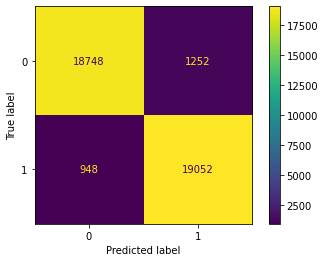

In [62]:
plot_confusion_matrix(multinomial, X_test, y_test)
plt.show()

In [63]:
user_review = input("Please enter a review: ")
# convert to lower case
user_review = user_review.lower()
# remove URLs and HTML
user_review = user_review.replace(r'http\S+', r'')
user_review = re.sub('<[^<]+?>', '', user_review)
# perform contractions
user_review = expandWord(user_review)
# convert to lower case agProcess finished with exit code 132 (interrupted by signal 4: SIGILL)ain
user_review = user_review.lower()
# remove non alphabetical characters
user_review = re.sub(r'[^A-Za-z ]+', '', user_review)
# remove extra spaces between words
user_review = re.sub(' +', ' ', user_review)
# remove stop words
user_review = ' '.join([word for word in user_review.split() if word not in (stop)])
# perform lemmatization
user_review = " ".join([lemmatizer.lemmatize(str(w)) for w in user_review.split()])
user_review = vectorizer.transform([user_review])
# predict sentiment
predict = multinomial.predict(user_review)
print("The sentiment for the review is: ", predict)

Please enter a review: I love it so much!!
The sentiment for the review is:  [1]
